In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt 
import torch as T 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import os 
from utility import *
from agent import *
from pid_performance import *

In [2]:
# descrive the system state, position and heading 
class State(): 
    
    def __init__(self, x_, y_, theta_):
    
        if not (x_ is None or y_ is None or theta_ is None ):  
        
            
            self.x = x_ 
            
            self.y = y_ 
            
            self.theta = theta_ 
            
        else : 
            
            self.x = 0 
            
            self.y= 0
            
            self.theta= 0
            
    def __str__(self): 
        
        
        return str(self.x)+","+str(self.y)+","+str(self.theta)
    
    def distance_form_state(self,other): 
        
        
        distance = np.array([self.x-other.x,self.y-other.y])
        
        distance_err = distance@distance
        
        return distance_err
         

In [3]:
class Controller():
    
    def __init__(self, goal, start, R_=0.0325, L_=0.1, dT=0.1, v_=1, arrive_distance=0.3): 
    
        self.R = R_   #radius of the wheel 
    
        self.L = L_   #length of the differential drive robot 
    
        self.E = 0 #cumulative error for integration 
    
        self.old_e = 0  #previous error 
    
        self.v = v_   #the velocity is kept constant 
    
        self.dt = dT   #time_step 
    
        self.arrive_distance = arrive_distance 
    
        self.goal = goal 
    
        self.current_position = start 
    
        self.route_x = [] 
    
        self.route_y = [] 
    
        self.route_theta = [] 
        
    def track_route(self): 
        
        self.route_x.append(self.current_position.x)
        
        self.route_y.append(self.current_position.y)
        
        self.route_theta.append(self.current_position.theta)
        
   
    def give_route(self): 
        
        time = [i*self.dt for i in range(len(self.route_x))]
        
        return self.route_x, self.route_y, self.route_theta, time 
    
    def fixAngle(self,angle): 
        
        return np.arctan2(np.sin(angle), np.cos(angle))
                          
    def iterate(self): 
        """
        Method for the pid tuning using RL
        
        """
                          
        dx = self.goal.x - self.current_position.x 
                          
        dy = self.goal.y -self.current_position.y 
                          
        g_theta = np.arctan2(dy, dx)
        
        alpha = g_theta - self.current_position.theta
                          
        e = np.arctan2(np.sin(alpha), np.cos(alpha))
                          
        
        e_p = e
        
        e_I = self.E + e 
        
        e_D = e -self.old_e 
        
        self.E = self.E + e
        
        self.old_e = e
        
        a =np.array([e_p,e_I,e_D])
        
        return a 
          
    def iterate_with_gains(self,k,ki,kd): 
                          
        """
        this function should only be used once the controller parameters have been found, 
        it is not part of the training (at least for validation and testing)
        """
        
        dx = self.goal.x - self.current_position.x  
        
        dy = self.goal.y -self.current_position.y   
   
        g_theta = np.arctan2(dy, dx)
        
    
        alpha = g_theta - self.current_position.theta
   
        e = np.arctan2(np.sin(alpha), np.cos(alpha))

        e_p = e 
        
        e_I = self.E + e 
        
        e_D = e -self.old_e 
        
        self.E = self.E + e
        
        self.old_e = e
        
        w = k*e_p + ki*e_I + kd*e_D
        
        return w 
    
    def make_action(self, w):
      
        x_dt = self.v*np.cos(self.current_position.theta)   
        
        y_dt = self.v*np.sin(self.current_position.theta)
        
        
        
        a = self.current_position.x + x_dt * self.dt
        
        b = self.current_position.y + y_dt * self.dt
        
  
        

        self.current_position.x = self.current_position.x + x_dt * self.dt
        
        self.current_position.y = self.current_position.y + y_dt * self.dt
        
        theta_dt = w
        self.current_position.theta = (self.fixAngle(
            self.current_position.theta + self.fixAngle(theta_dt * self.dt))).squeeze(-1)
       
        
        return 
                          
    def isArrived(self):
                          
        distance = self.current_position.distance_form_state(self.goal)
        
        if distance < self.arrive_distance:
        
            return True
        else:
            return False
    
    
    

In [4]:
#initialize the agent for the pid tuning 
#the agent takes as input the error state and decide the next action
#the action is the angular velocity of the robot 

In [159]:
agent = Agent(3,chkpt_dir = "model_") # ,device='cpu') 


In [12]:
EPISODES = 2000
best_score = -111000
score_history = [] 
expl_noise = 0.25

In [13]:
np.random.seed(15)

In [14]:
test = False 

In [15]:
#training 

In [16]:
for i in range(EPISODES): 

    print(i, end='\r')
    
    a = np.random.uniform(-40,40,2)
    
    b = np.random.uniform(0,90,2)
    
    spatial_state = State(a[0],a[1],np.radians(b[0]))
    
    target_distance = 0 
    
    while (target_distance<36 or target_distance>38):
        
        t_coord = np.random.uniform(-40,40,2)
        
        target = State(t_coord[0],t_coord[1],np.radians(b[0]))
        
        target_distance = spatial_state.distance_form_state(target)
        
        # I make sure that the distance between start_position and goal is on average the same 
        #so that the reward is balanced 
        
    controller = Controller(target,spatial_state)
    
    done = False 
    
    error_state = controller.iterate()
    
    score = 0 
    
    expl_noise = 0.25 
    
    num_steps = 0 
    
    h = 0 
    
    while not done: 
        
        h+=1 
        
        num_steps += 1 
        
        action = agent.choose_action(error_state, expl_noise)
        
        controller.make_action(action)
        
        done_ = controller.isArrived() 
        
        new_error_state = controller.iterate() 
        
        if done_: 
            
            reward = 200 
            
        else : 
            
            reward = -new_error_state[0]**2
            
        
        done = done_ 
        
        if num_steps>=800: 
            
            done = True 
            
        agent.store_transition(error_state, action, reward, new_error_state, done)
        
        error_state = new_error_state 
        
        agent.train() 
        
        score += reward 
        
    score_history.append(score)   
    avg_score = np.mean(score_history[-50:])
        
        
    if avg_score > best_score:  
        
        best_score = avg_score 
    
        agent.save_models() 
        
    if(i%10==0): 
        
        print("Results during training procedure:") 
            
        print('episode ', i, 'score %.1f' % score, 'average score %.1f' % avg_score)
                    
        
        
     
    

Results during training procedure:
episode  0 score -5411.8 average score -5411.8
End of warmup
Results during training procedure:
episode  10 score 197.9 average score -661.6
Results during training procedure:
episode  20 score 113.5 average score -283.5
Results during training procedure:
episode  30 score 100.8 average score -141.9
Results during training procedure:
episode  40 score 179.2 average score -82.6
Results during training procedure:
episode  50 score 184.9 average score 73.6
Results during training procedure:
episode  60 score 195.4 average score 147.4
Results during training procedure:
episode  70 score 185.0 average score 158.4
Results during training procedure:
episode  80 score 187.0 average score 165.5
Results during training procedure:
episode  90 score 197.8 average score 184.0
Results during training procedure:
episode  100 score 198.2 average score 189.1
Results during training procedure:
episode  110 score 187.5 average score 189.8
Results during training procedu

Results during training procedure:
episode  1030 score 198.8 average score 179.8
Results during training procedure:
episode  1040 score 198.8 average score 180.8
Results during training procedure:
episode  1050 score 146.3 average score 179.5
Results during training procedure:
episode  1060 score 198.8 average score 181.1
Results during training procedure:
episode  1070 score 198.6 average score 181.3
Results during training procedure:
episode  1080 score 198.9 average score 182.9
Results during training procedure:
episode  1090 score 198.4 average score 182.2
Results during training procedure:
episode  1100 score 181.0 average score 184.5
Results during training procedure:
episode  1110 score 198.3 average score 184.9
Results during training procedure:
episode  1120 score 197.9 average score 187.2
Results during training procedure:
episode  1130 score 198.9 average score 188.2
Results during training procedure:
episode  1140 score 193.4 average score 186.0
Results during training proc

In [17]:
x = [i for i in range(len(score_history))]

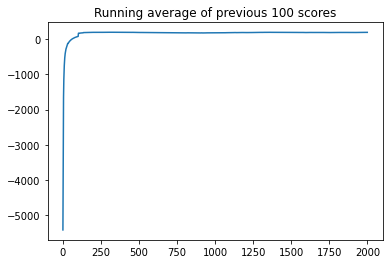

In [20]:
plot_average_reward(x,score_history,"Training.png")

In [32]:
xx = x[2:]
score_history_ = score_history[2:]

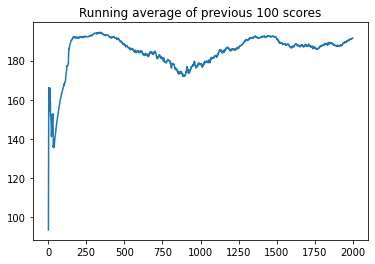

In [35]:
plot_average_reward(xx,score_history_,"Training_2.png")

In [36]:
#I use the pid parameters of the best model, because now in the agent are saved the acor weights of the final model

In [124]:
#load best model 
agent.load_actor() 

In [4]:
#previous model saved 
agent = Agent(3,chkpt_dir = "slow_model") 

In [5]:
agent.load_actor()

In [6]:
#pid parameters -> weights of the actor 
k = abs(agent.actor.mu.weight[0].item())
ki= abs(agent.actor.mu.weight[1].item())
kd = abs(agent.actor.mu.weight[2].item())

In [7]:
np.random.seed(10)

In [8]:
test_ep=5

In [9]:
x = []
y = []
th = []
t = [] 
target_list = [] 

In [10]:
for i in range(test_ep): 
    
    a = np.random.uniform(-40,40,4)
    
    b = np.random.uniform(0,90,2)
    
    spatial_state = State(a[0],a[1],np.radians(b[0]))
    
    target = State(a[2],a[3],np.radians(b[1]))
    target_list.append(target)
    controller = Controller(target,spatial_state)
    
    done = False 
    
    num_steps = 0
    
    controller.track_route()
    
    while not done: 
        
        w = controller.iterate_with_gains(k,ki,kd)
        
        controller.make_action(w) 
        
        done = controller.isArrived() 
        
        if done: 
            
            print("episode ",i,"success")
            
        num_steps += 1 
        
        if num_steps >= 800: 
            
            done = True 
            
            print("Target not reached")
            
        controller.track_route()
        
        if done: 
            
            a,b,c,time = controller.give_route()
            
            x.append(a)
            y.append(b)
            th.append(c)
            t.append(time)
        
                

        
        
    
    
    
    

episode  0 success
episode  1 success
episode  2 success
episode  3 success
episode  4 success


In [11]:
#reference signals 
ref = [] 
pid_dir = []

In [12]:
for h in range (test_ep): 
    ref_ = []
    pid_ = []
    for i in range(len(x[h])-1): 
        xx = x[h]
        yy = y[h]
        target= target_list[h]
        
        dy = target.y - yy[i]
        dx = target.x - xx[i]
        
        ref_.append(np.arctan2(dy,dx))
        
        dy = yy[i+1]-yy[i]
        dx = xx[i+1] -xx[i]
        
        pid_.append(np.arctan2(dy,dx))
    ref.append(ref_)
    pid_dir.append(pid_)    

In [13]:
i =0

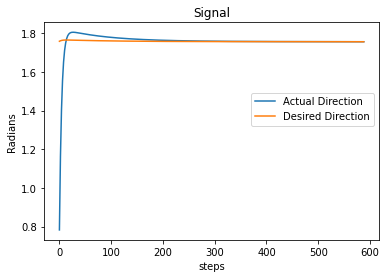

In [15]:
plt.plot(pid_dir[i],label='Actual Direction')
plt.plot(ref[i],label = 'Desired Direction')
plt.title("Signal")
plt.xlabel("steps")
plt.ylabel("Radians")
plt.legend(bbox_to_anchor=(1.0,0.7))

In [16]:
x0 = np.asarray(pid_dir[0]) 
ref0 = np.asarray(ref[0])
time0 = t[0]

In [17]:
overshoot_ = overshoot(x0,ref0) 

In [18]:
overshoot_

0.04087

In [19]:
rise_time_ = rise_time(x0,ref0,time0)

In [20]:
rise_time_ 

1.4000000000000001

In [21]:
settling_time_ = settling_time(x0,ref0,t[0],perc=0.5)


In [22]:
t[0][-1]  #final time of simulation

58.900000000000006

In [23]:
settling_time_ 

11.4

In [24]:
err_ = steady_state_error(x0,ref0)

In [25]:
err_ 

0.0001

In [26]:
targ = target_list[0]
#animation 
animation_plot(x[0],y[0],targ.x,targ.y,file_name="animation_only_target.gif")